In [ ]:
import nltk
print(nltk.__version__)

3.9.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
import os


repo_name = "LLM"
if not os.path.exists(repo_name):
    print("Repository does not exist. Cloning now...")

    !git clone https://github.com/sakibsh/LLM.git
else:
    print(f"Repository '{repo_name}' already exists.")


%cd LLM

# List the files to verify the dataset
!ls


Repository does not exist. Cloning now...
Cloning into 'LLM'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 38 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 24.57 MiB | 4.52 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/LLM
data  README.md


In [ ]:
!ls data


BARD  file  GPT  Human


In [ ]:
def load_file_with_prompts(file_path, content_type, source):
    # Load the file
    data = pd.read_csv(file_path)
    # Keep both prompts and responses (BARD column)
    data = data[['prompts', 'BARD']].rename(columns={'BARD': 'text'})
    # Assign labels
    data['content_type'] = content_type
    data['source'] = source
    return data

In [ ]:
bard_files = {
    "BARD_essay.csv": "essay",
    "BARD_poetry.csv": "poetry",
    "BARD_pycode.csv": "code",
    "BARD_story.csv": "story"
}

In [ ]:
base_dir = "/content/LLM/data"

In [ ]:
bard_data = pd.concat(
    [load_file_with_prompts(os.path.join(base_dir, "BARD", file), content_type, "BARD") for file, content_type in bard_files.items()],
    ignore_index=True
)

In [ ]:
print("BARD Data Shape:", bard_data.shape)
print(bard_data.head())

BARD Data Shape: (997, 4)
                                             prompts  \
0   According to some people, elderly drivers sho...   
1   Many people believe that television violence ...   
2   Medical researchers, cosmetic companies, and ...   
3   In order to save money, your principal is thi...   
4   Some people are actively involved in promotin...   

                                                text content_type source  
0  I think the issue of elderly drivers is a comp...        essay   BARD  
1  \nI agree that television violence has a negat...        essay   BARD  
2  I understand the concerns of people who are op...        essay   BARD  
3  Dear Principal,\n\nI am writing to you today t...        essay   BARD  
4  Yes, there is a cause that I actively support:...        essay   BARD  


In [ ]:
print(bard_data.tail())

                                               prompts  \
992  Tell the story of a group of warriors chosen t...   
993  Imagine a world where people have the power to...   
994  Write a story about a character who can commun...   
995  Tell the story of a person who discovers a hid...   
996  Imagine a world where people have the ability ...   

                                                  text content_type source  
992  \nThe year is 2042. The world is a very differ...        story   BARD  
993  \nThe year is 2042. The world is a very differ...        story   BARD  
994  \nThe girl's name was Akari, and she had a ver...        story   BARD  
995  \nThe year is 2042. The world is a very differ...        story   BARD  
996  \nThe year is 2042. The world is a very differ...        story   BARD  


In [ ]:
def load_file_with_prompts(file_path, content_type, source):
    # Load the file
    data = pd.read_csv(file_path)

    # Check the file structure
    if 'prompts' in data.columns and 'responses' in data.columns:
        # Standard structure with prompts and responses
        data = data[['prompts', 'responses']].rename(columns={'responses': 'text'})
    elif 'Title' in data.columns and 'Chapter_text' in data.columns:
        # Story structure with Title and Chapter_text
        data = data[["Title", "Chapter_text"]].rename(columns={"Title": "prompts", "Chapter_text": "text"})

        # Add a placeholder for prompts

    else:
        raise ValueError(f"Unknown file structure in file: {file_path}")

    # Assign labels
    data['content_type'] = content_type
    data['source'] = source
    return data



gpt_files = {
    "ChatGPT_essay.csv": "essay",
    "ChatGPT_poetry.csv": "poetry",
    "ChatGPT_pycode.csv": "code",
    "ChatGPT_story.csv": "story"
}

# Load and combine all GPT data
processed_files = []
for file, content_type in gpt_files.items():
    file_path = os.path.join(base_dir, "GPT", file)
    print(f"Processing file: {file_path}")
    if not os.path.exists(file_path):
        print(f"Error: File not found: {file_path}")
        continue
    try:
        df = load_file_with_prompts(file_path, content_type, "GPT")
        processed_files.append(df)
    except ValueError as e:
        print(e)

gpt_data = pd.concat(processed_files, ignore_index=True)

# Check combined GPT data
print("GPT Data Shape:", gpt_data.shape)
print(gpt_data.head())


Processing file: /content/LLM/data/GPT/ChatGPT_essay.csv
Processing file: /content/LLM/data/GPT/ChatGPT_poetry.csv
Processing file: /content/LLM/data/GPT/ChatGPT_pycode.csv
Processing file: /content/LLM/data/GPT/ChatGPT_story.csv
GPT Data Shape: (794, 4)
                                             prompts  \
0   According to some people, elderly drivers sho...   
1   Many people believe that television violence ...   
2   Medical researchers, cosmetic companies, and ...   
3   In order to save money, your principal is thi...   
4   Some people are actively involved in promotin...   

                                                text content_type source  
0    On one hand, some elderly drivers may have h...        essay    GPT  
1   Some people agree that television violence ha...        essay    GPT  
2    Some of the pros of animal testing are:  Ani...        essay    GPT  
3    Field trips are an important part of the edu...        essay    GPT  
4    Climate change is a global i

In [ ]:
def load_file_with_prompts(file_path, content_type, source):
    # Load the file
    data = pd.read_csv(file_path)

    # Check the file structure
    if 'Task' in data.columns and 'Code' in data.columns:
        # Standard structure with prompts and responses
        data = data[['Task', 'Code']].rename(columns={"Task": "prompts", "Code": "text"})
    elif 'ID' in data.columns and 'essay' in data.columns:
        # Story structure with Title and Chapter_text
        data = data[["essay"]].rename(columns={"essay": "text"})
    elif 'ID' in data.columns and 'essays' in data.columns:
        # Story structure with Title and Chapter_text
        data = data[["essays"]].rename(columns={"essays": "text"})

    elif 'question' in data.columns and 'text' in data.columns:
        data = data[["question", "text"]].rename(columns={"question": "prompts"})

    elif 'instructions' in data.columns and 'essays' in data.columns:
        # Story structure with Title and Chapter_text
        data = data[["instructions","essays" ]].rename(columns={"instructions": "prompts","essays": "text"})

    elif 'Poem' in data.columns and 'Poet' in data.columns:
        # Story structure with Title and Chapter_text
        data = data[["Poem" ]].rename(columns={"Poem": "text"})


    elif 'Title' in data.columns and 'Chapter_text' in data.columns:
        # Human stories structure
        data = data[["Title", "Chapter_text"]].rename(columns={"Title": "prompts", "Chapter_text": "text"})
    else:
        raise ValueError(f"Unknown file structure in file: {file_path}")

    # Assign labels
    data['content_type'] = content_type
    data['source'] = source
    return data



human_files = {
    "human_essay_1.csv": "essay",
    "human_essay_2.csv": "essay",
    "human_essay_hewlett.csv": "essay",
    "human_essay_hugg.csv": "essay",
    "human_poetry.csv": "poetry",
    "human_code.csv": "code",
    "human_stories.csv": "story"
}

In [ ]:
processed_files = []
for file, content_type in human_files.items():
    file_path = os.path.join(base_dir, "Human", file)
    print(f"Processing file: {file_path}")
    if not os.path.exists(file_path):
        print(f"Error: File not found: {file_path}")
        continue
    try:
        df = load_file_with_prompts(file_path, content_type, "Human")
        processed_files.append(df)
    except ValueError as e:
        print(e)

human_data = pd.concat(processed_files, ignore_index=True)

Processing file: /content/LLM/data/Human/human_essay_1.csv
Processing file: /content/LLM/data/Human/human_essay_2.csv
Processing file: /content/LLM/data/Human/human_essay_hewlett.csv
Processing file: /content/LLM/data/Human/human_essay_hugg.csv
Processing file: /content/LLM/data/Human/human_poetry.csv
Processing file: /content/LLM/data/Human/human_code.csv
Processing file: /content/LLM/data/Human/human_stories.csv


In [ ]:
gpt_data.head()

,prompts,text,content_type,source
0,"According to some people, elderly drivers sho...","On one hand, some elderly drivers may have h...",essay,GPT
1,Many people believe that television violence ...,Some people agree that television violence ha...,essay,GPT
2,"Medical researchers, cosmetic companies, and ...",Some of the pros of animal testing are: Ani...,essay,GPT
3,"In order to save money, your principal is thi...",Field trips are an important part of the edu...,essay,GPT
4,Some people are actively involved in promotin...,Climate change is a global issue that affect...,essay,GPT


In [ ]:
print(gpt_data['content_type'].value_counts())
print(bard_data['content_type'].value_counts())

content_type
poetry    250
code      249
essay     200
story      95
Name: count, dtype: int64
content_type
story     300
poetry    250
code      249
essay     198
Name: count, dtype: int64


In [ ]:
 # Check unique values in the content_type column


In [ ]:
print(human_data.head())
print(human_data['content_type'].value_counts())


                                                text content_type source  \
0  I just got back from your class, so I decided ...        essay  Human   
1  It is 9:35 and I am beginning my stream of con...        essay  Human   
2  Not only was the server down but it has taken ...        essay  Human   
3  I am not exactly sure how this is supposed to ...        essay  Human   
4  Well, here I am on Friday, September something...        essay  Human   

  prompts  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
content_type
essay     17680
poetry    13854
code       4608
story       180
Name: count, dtype: int64


In [ ]:
print(human_data.columns)  # List all columns
print(human_data['content_type'].unique())

Index(['text', 'content_type', 'source', 'prompts'], dtype='object')
['essay' 'poetry' 'code' 'story']


In [ ]:
# Set the maximum size per content type
max_samples_per_type = 1000

# Function to downsample or keep data as is
def downsample_group(group):
    if len(group) > max_samples_per_type:
        return group.sample(n=max_samples_per_type, random_state=42)
    return group

# Group by content_type and apply downsampling
balanced_human_data = human_data.groupby('content_type', group_keys=False).apply(downsample_group)

# Shuffle the dataset to mix all content types
balanced_human_data = balanced_human_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution
print("New Distribution of Content Types:")
print(balanced_human_data['content_type'].value_counts())


New Distribution of Content Types:
content_type
essay     1000
code      1000
poetry    1000
story      180
Name: count, dtype: int64


<ipython-input-20-7e01dfbcd394>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_human_data = human_data.groupby('content_type', group_keys=False).apply(downsample_group)


In [ ]:
all_data = pd.concat([bard_data, gpt_data, balanced_human_data], ignore_index= True)

all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(balanced_human_data.shape)
print(gpt_data.shape)
print(bard_data.shape)

(3180, 4)
(794, 4)
(997, 4)


In [ ]:
print(all_data.shape)

(4971, 4)


In [ ]:
data = all_data.dropna(subset=['text'])


data['text'] = data['text'].str.strip()
data['prompts'] = data['prompts'].str.strip()

print("Data after cleaning:")
print(data.info())

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 4897 entries, 0 to 4970
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompts       3026 non-null   object
 1   text          4897 non-null   object
 2   content_type  4897 non-null   object
 3   source        4897 non-null   object
dtypes: object(4)
memory usage: 191.3+ KB
None


<ipython-input-24-eb91f777014c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].str.strip()
<ipython-input-24-eb91f777014c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prompts'] = data['prompts'].str.strip()


Content Type Distribution:
content_type
poetry    1500
code      1430
essay     1398
story      569
Name: count, dtype: int64

Source Distribution:
source
Human    3112
BARD      995
GPT       790
Name: count, dtype: int64


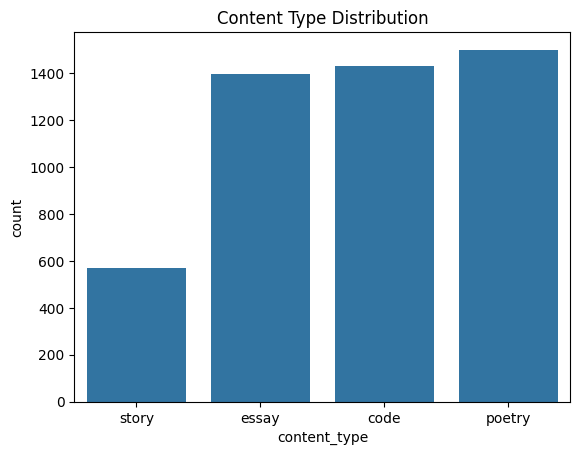

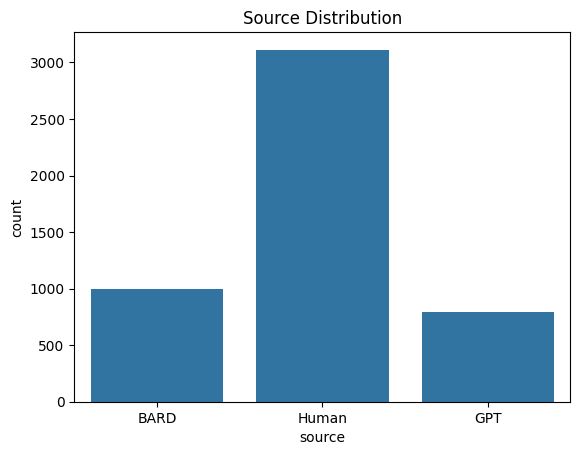

In [ ]:

print("Content Type Distribution:")
print(data['content_type'].value_counts())

print("\nSource Distribution:")
print(data['source'].value_counts())

# Visualize distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='content_type', data=data)
plt.title("Content Type Distribution")
plt.show()

sns.countplot(x='source', data=data)
plt.title("Source Distribution")
plt.show()


In [ ]:
# Separate data by content type
code_data = data[data['content_type'] == 'code']
story_data = data[data['content_type'] == 'story']
essay_data = data[data['content_type'] == 'essay']
poetry_data = data[data['content_type'] == 'poetry']


In [ ]:
pip install transformers torch scikit-learn datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
content_types = ["code", "essay", "poetry", "story"]

datasets = {}
for content_type in content_types:
    subset = data[data["content_type"] == content_type]
    X_train, X_test, y_train, y_test = train_test_split(
        subset["text"], subset["source"], test_size=0.2, stratify=subset["source"], random_state=42
    )
    datasets[content_type] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for content_type in content_types:
    datasets[content_type]["y_train_encoded"] = label_encoder.fit_transform(datasets[content_type]["y_train"])
    datasets[content_type]["y_test_encoded"] = label_encoder.transform(datasets[content_type]["y_test"])

# Save the label mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)  # Example: {'Human': 0, 'BARD': 1, 'GPT': 2}


{'BARD': 0, 'GPT': 1, 'Human': 2}


In [ ]:
from transformers import AlbertTokenizer

# Initialize the tokenizer for ALBERT
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Tokenize the data
for content_type in content_types:
    train_encodings = tokenizer(
        list(datasets[content_type]["X_train"]),
        truncation=True,
        padding=True,
        max_length=512,
    )
    test_encodings = tokenizer(
        list(datasets[content_type]["X_test"]),
        truncation=True,
        padding=True,
        max_length=512,
    )
    datasets[content_type]["train_encodings"] = train_encodings
    datasets[content_type]["test_encodings"] = test_encodings


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", num_labels=3
)


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}  # Convert to tensors
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensors

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item


for content_type in content_types:
    datasets[content_type]["train_dataset"] = TextDataset(
        datasets[content_type]["train_encodings"], datasets[content_type]["y_train_encoded"]
    )
    datasets[content_type]["test_dataset"] = TextDataset(
        datasets[content_type]["test_encodings"], datasets[content_type]["y_test_encoded"]
    )


In [ ]:
# Check a single dataset item
sample_item = datasets["essay"]["train_dataset"][0]
print(sample_item)  # Should contain tensors for input_ids, attention_mask, and labels


{'input_ids': tensor([    2,  4483,  7807,    13,     1,  6826,  1829,   165,    14,    13,
            1, 19032,   240,    15,    19,    48,    85,   557,   796,    13,
            1,  4666,    18,  4048,    13,     1,  4666,    18,  3412, 21719,
          140,    13,    38,  7673,   103,  4202,    15,    13,     1,  4666,
           18,   165,    15,    13,     1,  4666,    18,   135,    15,    13,
            1,  4666,    18,   240,    15,    29,    14,    13,     1,  4666,
           18,  1036,     9,   753,    68,   140,    13,     1,  4666,    18,
          300,    86,   976,    17,   366,    13,     1,  4666,    18,   264,
           13,     1,  4666,    18,  3412,    13,     1,  4666,    18,  4048,
          174,    57,    85,    20,   747,    17,  3408,    14,    13,   661,
         6105,    18,    60,   148,    50,    90,  1045,    35, 17447,   854,
          699,    35,    14,  3842,    13,     1,  4666,    18,   379,    19,
           14,  1080,    54,    35,    13,     1, 

In [ ]:
print(content_types)

['code', 'essay', 'poetry', 'story']


In [ ]:
models = {}
for content_type in content_types:
    models[content_type] = AlbertForSequenceClassification.from_pretrained(
        "albert-base-v2", num_labels=3
    )


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are new

In [ ]:
from transformers import AdamW

optimizers = {}
for content_type in content_types:
    optimizers[content_type] = AdamW(models[content_type].parameters(), lr=5e-5)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def custom_collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [ ]:
from torch.utils.data import DataLoader

train_loaders = {}
test_loaders = {}

for content_type in content_types:
    train_loaders[content_type] = DataLoader(
        datasets[content_type]["train_dataset"], batch_size=16, shuffle=True
    )
    test_loaders[content_type] = DataLoader(
        datasets[content_type]["test_dataset"], batch_size=16
    )


In [ ]:
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = {}
for content_type in content_types:
    y_train = datasets[content_type]["y_train_encoded"]
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    weights = [total_samples / (len(class_counts) * count) for count in class_counts]
    class_weights[content_type] = torch.tensor(weights, dtype=torch.float).to(device)

    print(f"Class weights for {content_type}: {weights}")


Class weights for code: [1.9259259259259258, 1.916247906197655, 0.5104863900044623]
Class weights for essay: [2.3586497890295357, 2.3291666666666666, 0.4658333333333333]
Class weights for poetry: [2.0, 2.0, 0.5]
Class weights for story: [0.6319444444444444, 2.077625570776256, 1.068075117370892]


In [ ]:
import torch.nn as nn

loss_functions = {}
for content_type in content_types:
    loss_functions[content_type] = nn.CrossEntropyLoss(weight=class_weights[content_type])


In [ ]:
from tqdm import tqdm  # Import tqdm for progress bars
import torch

for content_type in content_types:
    print(f"Training model for {content_type}...")
    model = models[content_type].to(device)  # Send model to device
    optimizer = optimizers[content_type]
    train_loader = train_loaders[content_type]
    loss_function = loss_functions[content_type]

    model.train()
    for epoch in range(3):  # Number of epochs
        print(f"Epoch {epoch+1}/3")

        # Wrap the train_loader with tqdm
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)  # Send input_ids to device
            attention_mask = batch["attention_mask"].to(device)  # Send attention_mask to device
            labels = batch["labels"].to(device)  # Send labels to device

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_function(outputs.logits, labels)  # Use custom loss function
            loss.backward()
            optimizer.step()

            # Update the progress bar with loss value
            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())


Training model for code...
Epoch 1/3


Epoch 1: 100%|██████████| 72/72 [01:44<00:00,  1.45s/it, loss=0.0411]


Epoch 2/3


Epoch 2: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it, loss=0.013]


Epoch 3/3


Epoch 3: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it, loss=0.277]


Training model for essay...
Epoch 1/3


Epoch 1: 100%|██████████| 70/70 [01:46<00:00,  1.53s/it, loss=0.0578]


Epoch 2/3


Epoch 2: 100%|██████████| 70/70 [01:46<00:00,  1.53s/it, loss=0.129]


Epoch 3/3


Epoch 3: 100%|██████████| 70/70 [01:46<00:00,  1.53s/it, loss=0.111]


Training model for poetry...
Epoch 1/3


Epoch 1: 100%|██████████| 75/75 [01:52<00:00,  1.51s/it, loss=1.04]


Epoch 2/3


Epoch 2: 100%|██████████| 75/75 [01:52<00:00,  1.50s/it, loss=0.141]


Epoch 3/3


Epoch 3: 100%|██████████| 75/75 [01:52<00:00,  1.50s/it, loss=0.523]


Training model for story...
Epoch 1/3


Epoch 1: 100%|██████████| 29/29 [00:44<00:00,  1.53s/it, loss=0.159]


Epoch 2/3


Epoch 2: 100%|██████████| 29/29 [00:44<00:00,  1.53s/it, loss=0.411]


Epoch 3/3


Epoch 3: 100%|██████████| 29/29 [00:44<00:00,  1.53s/it, loss=0.0959]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate each model
for content_type in content_types:
    print(f"Evaluating model for {content_type}...")
    model = models[content_type].to(device)
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    # Loop through the test DataLoader
    for batch in test_loaders[content_type]:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    print(f"Classification Report for {content_type}:")
    print(classification_report(all_labels, all_preds, target_names=["Human", "BARD", "GPT"]))

    print(f"Confusion Matrix for {content_type}:")
    print(confusion_matrix(all_labels, all_preds))


Evaluating model for code...
Classification Report for code:
              precision    recall  f1-score   support

       Human       0.98      0.96      0.97        49
        BARD       0.84      0.98      0.91        50
         GPT       0.98      0.95      0.96       187

    accuracy                           0.95       286
   macro avg       0.94      0.96      0.95       286
weighted avg       0.96      0.95      0.96       286

Confusion Matrix for code:
[[ 47   0   2]
 [  0  49   1]
 [  1   9 177]]
Evaluating model for essay...
Classification Report for essay:
              precision    recall  f1-score   support

       Human       0.93      0.95      0.94        40
        BARD       0.90      0.95      0.93        40
         GPT       0.99      0.98      0.99       200

    accuracy                           0.97       280
   macro avg       0.94      0.96      0.95       280
weighted avg       0.97      0.97      0.97       280

Confusion Matrix for essay:
[[ 38   2   0

In [ ]:
import os

# Directory to save models
model_dir = "trained_models"
os.makedirs(model_dir, exist_ok=True)

# Save each model
for content_type in content_types:
    model_path = os.path.join(model_dir, f"{content_type}_model.pth")
    torch.save(models[content_type].state_dict(), model_path)
    print(f"Saved {content_type} model to {model_path}")


Saved code model to trained_models/code_model.pth
Saved essay model to trained_models/essay_model.pth
Saved poetry model to trained_models/poetry_model.pth
Saved story model to trained_models/story_model.pth


In [ ]:
from google.colab import drive
import torch
import os

# Mount Google Drive
drive.mount('/content/drive')

# Ensure the directory exists before saving
save_path = '/content/drive/MyDrive/trained_models'
os.makedirs(save_path, exist_ok=True)

# Save all models
models = {
    'essay': models['essay'],
    'code': models['code'],
    'poetry': models['poetry'],
    'story': models['story']
}

# Save each model to the specified path
for model_name, model in models.items():
    model_path = os.path.join(save_path, f"{model_name}_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"{model_name.capitalize()} model saved successfully at: {model_path}")


Mounted at /content/drive
Essay model saved successfully at: /content/drive/MyDrive/trained_models/essay_model.pth
Code model saved successfully at: /content/drive/MyDrive/trained_models/code_model.pth
Poetry model saved successfully at: /content/drive/MyDrive/trained_models/poetry_model.pth
Story model saved successfully at: /content/drive/MyDrive/trained_models/story_model.pth


In [ ]:
tokenizer.save_pretrained(save_path)
print(f"Tokenizer saved successfully at: {save_path}")

Tokenizer saved successfully at: /content/drive/MyDrive/trained_models
